# Step 3: Test, Train, Split, OneHotEncode, Model Function, GridSearch.

## Preprocessing

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
import datetime as dt

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from matplotlib import dates as mpl_dates
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import plot_confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV, cross_val_score, ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn import decomposition
from sklearn.pipeline import Pipeline
from sklearn import tree
from sklearn.metrics import accuracy_score
from sklearn import svm

In [2]:
df = pd.read_csv('data/cleaned_data')

In [3]:
df

,subject_age,stop_resolution,weapon_type,officer_age,officer_gender,officer_race,subject_race,subject_gender,date,initial_call_type,call_type,arrest,frisk
0,Under 17,Arrest,None,23,M,White,American Indian or Alaska Native,Male,2015-09-13,NaN,NaN,N,Y
1,Under 17,Field Contact,None,27,F,Not Specified,Unknown,Male,2015-04-19,NaN,NaN,N,Y
2,Under 17,Field Contact,None,27,M,White,White,Male,2015-04-20,NaN,NaN,N,N
3,Under 17,Field Contact,None,23,F,White,Black or African American,Male,2015-05-19,NaN,NaN,N,Y
4,Under 17,Field Contact,None,33,M,Nat Hawaiian/Oth Pac Islander,Black or African American,Male,2015-05-19,NaN,NaN,N,N
...,...,...,...,...,...,...,...,...,...,...,...,...,...
43914,56 and Above,Field Contact,NaN,31,M,White,White,Male,2021-07-14,NaN,NaN,N,N
43915,56 and Above,Arrest,NaN,31,M,Black or African American,Black or African American,Male,2019-07-17,SHOPLIFT - THEFT,911,Y,N
43916,56 and Above,Offense Report,NaN,50,M,White,Black or African American,Male,2019-11-08,PURSE SNATCH - ROBBERY,ONVIEW,N,N
43917,56 and Above,Field Contact,NaN,44,M,Hispanic or Latino,Black or African American,Male,2020-12-26,SHOPLIFT - THEFT,911,N,N


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 43919 entries, 0 to 43918
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subject_age        43919 non-null  object
 1   stop_resolution    43919 non-null  object
 2   weapon_type        32748 non-null  object
 3   officer_age        43919 non-null  int64 
 4   officer_gender     43919 non-null  object
 5   officer_race       43919 non-null  object
 6   subject_race       43919 non-null  object
 7   subject_gender     43919 non-null  object
 8   date               43919 non-null  object
 9   initial_call_type  31596 non-null  object
 10  call_type          31596 non-null  object
 11  arrest             43919 non-null  object
 12  frisk              43919 non-null  object
dtypes: int64(1), object(12)
memory usage: 4.4+ MB


### Splitting Data Set into X and Y

In [5]:
#isolate columns wanted to compare with frisk
frisk_columns = df.drop(columns=['frisk', 'date', 'subject_age'], axis=1)

#Establish X and y
y = df['frisk']
X = frisk_columns 

#Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

#Remove 'object'-type features from X
cont_features = [col for col in X.columns if X[col].dtype in [np.float64, np.int64]]

# Remove "object"-type features from X_train and X_test
X_train_cont = X_train.loc[:, cont_features]
X_test_cont = X_test.loc[:, cont_features]

In [6]:
print(y.shape)
print(X.shape)

(43919,)
(43919, 10)


### Imputing, Scaling, Encoding 

In [7]:
from sklearn.metrics import mean_squared_error, mean_squared_log_error
from sklearn.linear_model import LinearRegression
from sklearn.impute import SimpleImputer

# Impute missing values with median using SimpleImputer
impute = SimpleImputer(strategy='median')
X_train_imputed = impute.fit_transform(X_train_cont)
X_test_imputed = impute.transform(X_test_cont)

In [8]:
#normalize our data
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

# Scale the train and test data
ss = StandardScaler()
X_train_imputed_scaled = ss.fit_transform(X_train_imputed)
X_test_imputed_scaled = ss.transform(X_test_imputed)

In [9]:
# Create X_cat which contains only the categorical variables
features_cat = [col for col in X.columns if X[col].dtype in [np.object]]
X_train_cat = X_train.loc[:, features_cat]
X_test_cat = X_test.loc[:, features_cat]

# Fill missing values with the string 'missing'
X_train_cat.fillna(value='missing', inplace=True)
X_test_cat.fillna(value='missing', inplace=True)

In [10]:
from sklearn.preprocessing import OneHotEncoder

# OneHotEncode categorical variables
ohe = OneHotEncoder(handle_unknown='ignore')

# Transform training and test sets
X_train_ohe = ohe.fit_transform(X_train_cat)
X_test_ohe = ohe.transform(X_test_cat)

# Convert these columns into a DataFrame 
columns = ohe.get_feature_names(input_features=X_train_cat.columns)
cat_train_df = pd.DataFrame(X_train_ohe.todense(), columns=columns)
cat_test_df = pd.DataFrame(X_test_ohe.todense(), columns=columns)

In [11]:
#combining all the X_train categorial and continuous data
X_train_all = pd.concat([pd.DataFrame(X_train_imputed_scaled), cat_train_df], axis=1)
X_test_all = pd.concat([pd.DataFrame(X_test_imputed_scaled), cat_test_df], axis=1)

## Running our Train, Test split through Machine Learning Function

In [12]:
#Create a function within many Machine Learning Models for train data

def models(X_train_all, X_test_all, y_train, y_test):
    
    #Using Logistic Regression Algorithm to the Training Set
    log = LogisticRegression(random_state = 0, max_iter = 50000)
    log.fit(X_train_all, y_train)
    
    
    #Using KNeighborsClassifier Method of neighbors class to use Nearest Neighbor algorithm
    knn = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
    knn.fit(X_train_all, y_train)
    

    #Using SVC method of svm class to use Support Vector Machine Algorithm
    svc_lin = SVC(kernel = 'linear', random_state = 0)
    svc_lin.fit(X_train_all, y_train)
    
    #Using SVC method of svm class to use Kernel SVM Algorithm
    svc_rbf = SVC(kernel = 'rbf', random_state = 0)
    svc_rbf.fit(X_train_all, y_train)
    
    
    #Using GaussianNB method of naïve_bayes class to use Naïve Bayes Algorithm
    gauss = GaussianNB()
    gauss.fit(X_train_all, y_train)

    #Using DecisionTreeClassifier of tree class to use Decision Tree Algorithm
    tree = DecisionTreeClassifier(criterion = 'entropy', random_state = 0)
    tree.fit(X_train_all, y_train)
    
    #Using RandomForestClassifier method of ensemble class to use Random Forest Classification algorithm
    forest = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state = 0)
    forest.fit(X_train_all, y_train)
    
    print('[0]Logistic Regression Training Accuracy:', log.score(X_train_all, y_train))
    print('[1]K Nearest Neighbor Training Accuracy:', knn.score(X_train_all, y_train))
    print('[2]Support Vector Machine (Linear Classifier) Training Accuracy:', svc_lin.score(X_train_all, y_train))
    print('[3]Support Vector Machine (RBF Classifier) Training Accuracy:', svc_rbf.score(X_train_all, y_train))
    print('[4]Gaussian Naive Bayes Training Accuracy:', gauss.score(X_train_all, y_train))
    print('[5]Decision Tree Classifier Training Accuracy:', tree.score(X_train_all, y_train))
    print('[6]Random Forest Classifier Training Accuracy:', forest.score(X_train_all, y_train))
    
    print('[0]Logistic Regression Training Accuracy - X_test, y_test:', log.score(X_test_all, y_test))
    print('[1]K Nearest Neighbor Training Accuracy - X_test, y_test:', knn.score(X_test_all, y_test))
    print('[2]Support Vector Machine (Linear Classifier) Training Accuracy - X_test, y_test:', svc_lin.score(X_test_all, y_test))
    print('[3]Support Vector Machine (RBF Classifier) Training Accuracy - X_test, y_test:', svc_rbf.score(X_test_all, y_test))
    print('[4]Gaussian Naive Bayes Training Accuracy - X_test, y_test:', gauss.score(X_test_all, y_test))
    print('[5]Decision Tree Classifier Training Accuracy - X_test, y_test:', tree.score(X_test_all, y_test))
    print('[6]Random Forest Classifier Training Accuracy - X_test, y_test:', forest.score(X_test_all, y_test))
    
    return

In [13]:
models(X_train_all, X_test_all, y_train, y_test)

[0]Logistic Regression Training Accuracy: 0.8278070300270386
[1]K Nearest Neighbor Training Accuracy: 0.8449694037284758
[2]Support Vector Machine (Linear Classifier) Training Accuracy: 0.8267254874057208
[3]Support Vector Machine (RBF Classifier) Training Accuracy: 0.8265262558702149
[4]Gaussian Naive Bayes Training Accuracy: 0.29184573786822254
[5]Decision Tree Classifier Training Accuracy: 0.9419666998719226
[6]Random Forest Classifier Training Accuracy: 0.9286181869930269
[0]Logistic Regression Training Accuracy - X_test, y_test: 0.823884335154827
[1]K Nearest Neighbor Training Accuracy - X_test, y_test: 0.7929189435336976
[2]Support Vector Machine (Linear Classifier) Training Accuracy - X_test, y_test: 0.8227459016393442
[3]Support Vector Machine (RBF Classifier) Training Accuracy - X_test, y_test: 0.8247950819672131
[4]Gaussian Naive Bayes Training Accuracy - X_test, y_test: 0.2907559198542805
[5]Decision Tree Classifier Training Accuracy - X_test, y_test: 0.7815346083788707
[6]R

Based on the modeling of train and test data, our best models are SVM. KNN shows overfitting due to differences in train models vs test model.

### Confusion Matrix and Classification Report for RBF SVM

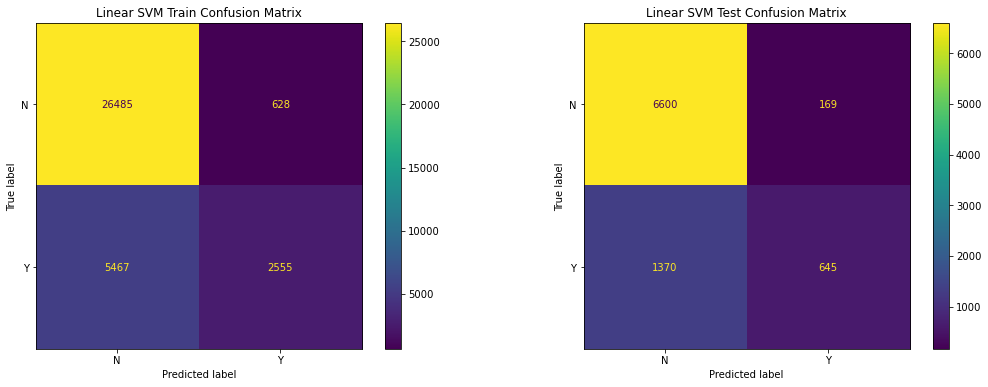

In [14]:
#start SVM confusion matrix

#instantiation
clf = svm.SVC(kernel='rbf')

#fitting
clf.fit(X_train_all, y_train)

#predictions
y_svm_hat_train = clf.predict(X_train_all)
y_svm_hat_test = clf.predict(X_test_all)

#plot decision tree confusion matrix
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 6))

plot_confusion_matrix(clf, X_train_all, y_train, ax=ax0)
plot_confusion_matrix(clf, X_test_all, y_test, ax=ax1)

ax0.title.set_text('Linear SVM Train Confusion Matrix')
ax1.title.set_text('Linear SVM Test Confusion Matrix')

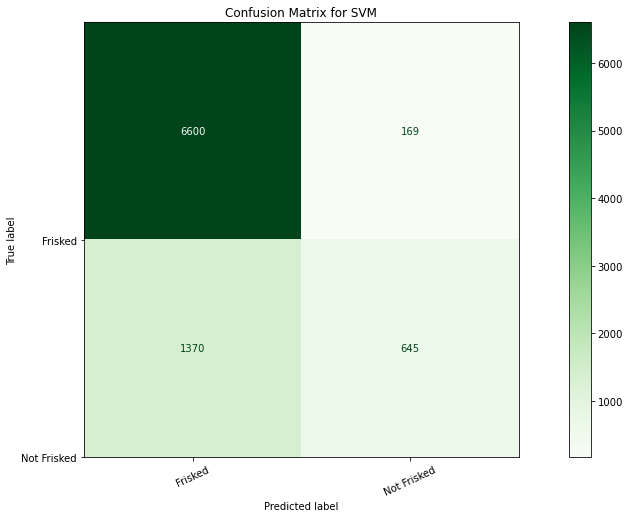

In [40]:
# Visualize your confusion matrix
fig, ax = plt.subplots(figsize=(18, 8))
plot_confusion_matrix(clf, X_test_all, y_test,
                     cmap=plt.cm.Greens, ax=ax)
# Add labels to the plot
class_names = ["Frisked", "Not Frisked"]
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix for SVM")
plt.show()

In [15]:
#run classification model for SVM
print(classification_report(y_train, y_svm_hat_train))
print(classification_report(y_test, y_svm_hat_test))

              precision    recall  f1-score   support

           N       0.83      0.98      0.90     27113
           Y       0.80      0.32      0.46      8022

    accuracy                           0.83     35135
   macro avg       0.82      0.65      0.68     35135
weighted avg       0.82      0.83      0.80     35135

              precision    recall  f1-score   support

           N       0.83      0.98      0.90      6769
           Y       0.79      0.32      0.46      2015

    accuracy                           0.82      8784
   macro avg       0.81      0.65      0.68      8784
weighted avg       0.82      0.82      0.79      8784



In [16]:
#run function to figure out most important feature
from sklearn import svm

def f_importances(coef, names, top=-1):
    imp = coef
    imp, names = zip(*sorted(list(zip(imp, names))))

    # Show all features
    if top == -1:
        top = len(names)

    plt.barh(range(top), imp[::-1][0:top], align='center')
    plt.yticks(range(top), names[::-1][0:top])
    plt.show()

# whatever your features are called
features_names = [X] 
svc = svm.SVC(kernel='rbf')
svc.fit(X_test_all, y_test)

p =f_importances(abs(svc.coef_[0]), X_test_all.columns.values, top=20)
p

AttributeError: coef_ is only available when using a linear kernel

In [ ]:
from sklearn.inspection import permutation_importance
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

svc = svm.SVC(kernel='rbf')
svc.fit(X_train_all, y_train)

perm_importance = permutation_importance(svc, X_test_all, y_test)

feature_names = [X]
features = np.array(feature_names)

sorted_idx = perm_importance.importances_mean.argsort()
plt.barh(features[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance")

### GridSearch for SVM

In [ ]:
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}


gs_svm = GridSearchCV(clf, param_grid, refit = True, verbose = 3)
gs_svm.fit(X_train_all, y_train)

print(gs_svm.best_params_)
print(grid.best_estimator_)

### Running the function with GridSearch Recommendations

In [ ]:
#test data
def svm_models(X_train_all, X_test_all, y_train, y_test):
    
    #Using RandomForestClassifier method of ensemble class to use Random Forest Classification algorithm
    svc1 = SVC(kernel = 'rbf', random_state = 0, gamma = 1, C= 25)
    svc1.fit(X_train_all, y_train)
    
    print('Support Vector Machine (Linear Classifier) Training Accuracy:', svc_lin.score(X_train_all, y_train))

    print('Support Vector Machine (Linear Classifier) Training Accuracy - X_test, y_test:', svc_lin.score(X_test_all, y_test))
    
    return

In [ ]:
svm_models(X_train_all, X_test_all, y_train, y_test)

Due to length of time it took to get the top features and perform a GridSearch, we were unable to find the top features and update the model with hyperparameters. We will run the GridSearch in the future and use the RandomForest model for top features.

### Random Forest Top Features

In [36]:
rfc1=RandomForestClassifier(random_state=0, max_features='auto', n_estimators= 500, max_depth=8, criterion='entropy')

In [37]:
rfc1.fit(X_train_all, y_train)

RandomForestClassifier(criterion='entropy', max_depth=8, n_estimators=500,
                       random_state=0)

In [38]:
pred=rfc1.predict(X_test_all)

In [39]:
print("Accuracy for Random Forest on CV data: ",accuracy_score(y_test,pred))

Accuracy for Random Forest on CV data:  0.8086293260473588


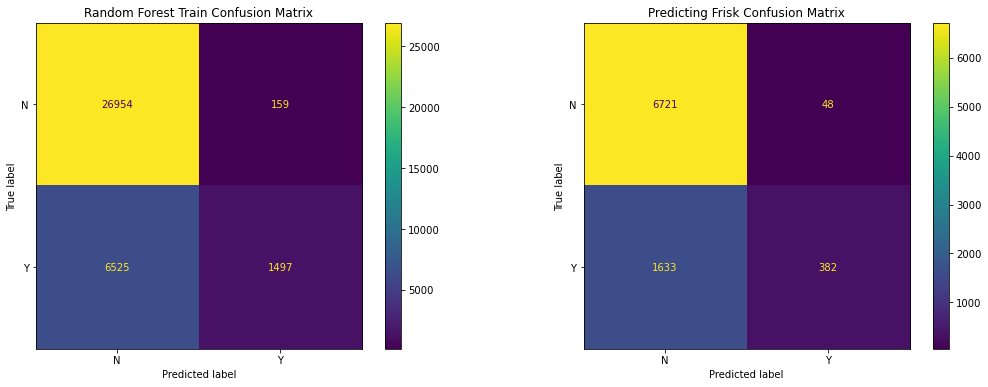

In [31]:
#start decision tree confusion matrix post Gridsearch

#instantiation
random_forest_2 = RandomForestClassifier(random_state=0, max_features='auto', n_estimators= 500, max_depth=8, criterion='entropy')

#fitting
random_forest_2.fit(X_train_all, y_train)

#predictions
y_forest_hat_train_2 = random_forest_2.predict(X_train_all)
y_forest_hat_test_2 = random_forest_2.predict(X_test_all)

#plot decision tree confusion matrix
fig, (ax0, ax1) = plt.subplots(1, 2, figsize=(18, 6))

plot_confusion_matrix(random_forest_2, X_train_all, y_train, ax=ax0)
plot_confusion_matrix(random_forest_2, X_test_all, y_test, ax=ax1)

ax0.title.set_text('Random Forest Train Confusion Matrix')
ax1.title.set_text('Predicting Frisk Confusion Matrix')

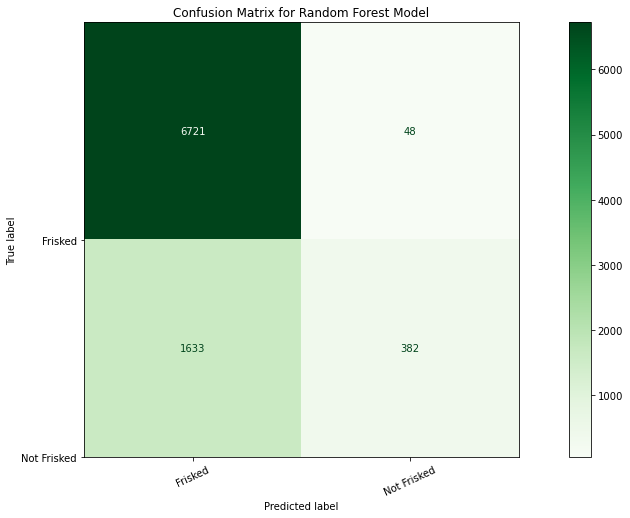

In [32]:
# Visualize your confusion matrix
fig, ax = plt.subplots(figsize=(18, 8))
plot_confusion_matrix(random_forest_2, X_test_all, y_test,
                     cmap=plt.cm.Greens, ax=ax)
# Add labels to the plot
class_names = ["Frisked", "Not Frisked"]
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.title("Confusion Matrix for Random Forest Model")
plt.show()

In [33]:
#run classification model for Random Forrest
print(classification_report(y_train, y_forest_hat_train_2))
print(classification_report(y_test, y_forest_hat_test_2))

              precision    recall  f1-score   support

           N       0.81      0.99      0.89     27113
           Y       0.90      0.19      0.31      8022

    accuracy                           0.81     35135
   macro avg       0.85      0.59      0.60     35135
weighted avg       0.83      0.81      0.76     35135

              precision    recall  f1-score   support

           N       0.80      0.99      0.89      6769
           Y       0.89      0.19      0.31      2015

    accuracy                           0.81      8784
   macro avg       0.85      0.59      0.60      8784
weighted avg       0.82      0.81      0.76      8784



In [34]:
random_forest_2.feature_importances_
fj = sorted(list(zip(random_forest_2.feature_importances_, X_train.columns)))
fj = pd.DataFrame(fj, columns=['Importance', 'Name'], )
fj

,Importance,Name
0,0.000000e+00,officer_race
1,8.581341e-07,subject_race
2,1.547022e-04,initial_call_type
3,3.807634e-04,arrest
4,1.057890e-03,call_type
5,9.427755e-03,subject_gender
6,9.469079e-03,officer_gender
7,1.556320e-02,stop_resolution
8,3.991327e-02,weapon_type
9,5.074232e-02,officer_age


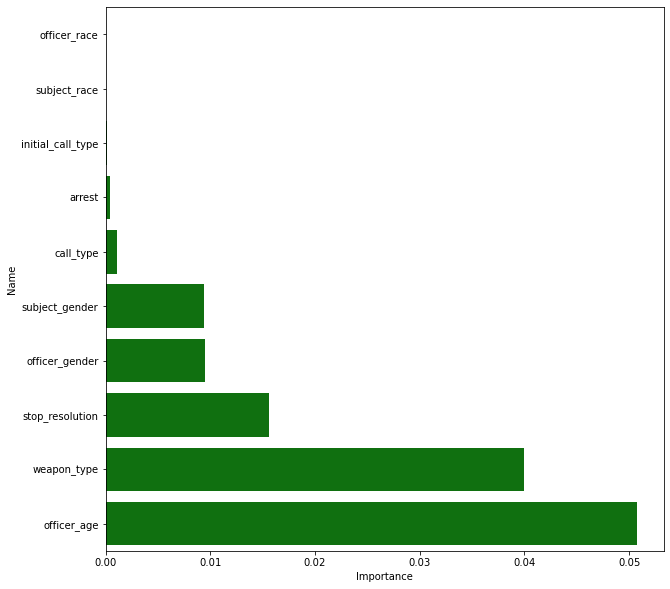

In [35]:
fig, ax=plt.subplots(figsize=(10,10))
sns.barplot(x='Importance', y='Name', data=fj,
           label='Feature Importance', color='g');

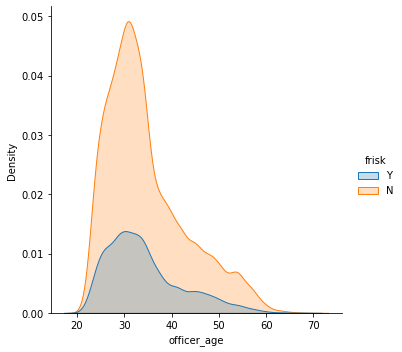

In [14]:
sns.displot(data=df, x='officer_age', hue='frisk', kind='kde', fill=True);

## SMOTE

In [10]:
import imblearn
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

from collections import Counter
from sklearn.datasets import make_classification
from matplotlib import pyplot
from numpy import where

In [11]:
y_train.value_counts()

NameError: name 'y_train' is not defined

In [113]:
oversample = SMOTE()

X_train_smote, y_train_smote = oversample.fit_resample(X_train_all, y_train)
print(X_train_smote.shape, y_train_smote.shape)

(54226, 208) (54226,)


In [114]:
y_train_smote.value_counts()

Y    27113
N    27113
Name: frisk, dtype: int64

In [115]:
model = DecisionTreeClassifier()
model.fit(X_train_smote,y_train_smote)

DecisionTreeClassifier()

In [117]:
# note predictions are on the non-smoted data!!!

train_preds = model.predict(X_train_all)
test_preds = model.predict(X_test_all)

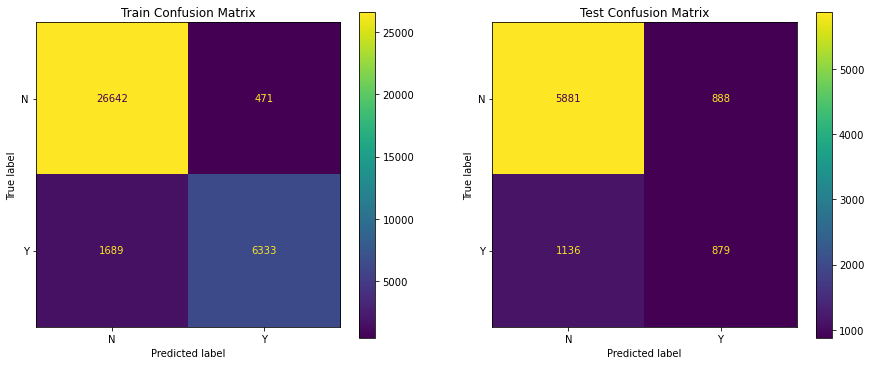

In [118]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

plot_confusion_matrix(model, X_train_all, y_train, ax=ax[0])
plot_confusion_matrix(model, X_test_all, y_test, ax=ax[1])
ax[0].grid(False)
ax[1].grid(False)
ax[0].title.set_text('Train Confusion Matrix')
ax[1].title.set_text('Test Confusion Matrix')

In [9]:
train_smote = model.predict(X_train_smote)
print(classification_report(y_train_all, train_preds))

NameError: name 'model' is not defined